In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import scipy.stats as st
import numpy as np
from lfpykernels import GaussCylinderPotential, KernelApprox
import neuron

# recompile mod files if needed
mech_loaded = neuron.load_mechanisms('mod')
if not mech_loaded:
    os.system('cd mod && nrnivmodl && cd -')
    mech_loaded = neuron.load_mechanisms('mod')
print(f'mechanisms loaded: {mech_loaded}')

# misc parameters
dt = 2**-4  # time resolution (ms)
t_X = 500  # time of synaptic activations (ms)
tau = 50  # duration of impulse response function after onset (ms)
Vrest = -65  # assumed average postsynaptic potential (mV)

X=['E', 'I']   # presynaptic population names
N_X = np.array([8192, 1024])  # presynpatic population sizes
Y = 'E' # postsynaptic population
N_Y = 8192  # postsynaptic population size
C_YX = np.array([0.05, 0.05])  # pairwise connection probability between populations X and Y
nu_X = {'E': 2.5, 'I': 5.0}  # assumed spike rates of each population (spikes/s)
g_eff = True  # account for changes in passive leak due to persistent synaptic activations

def set_passive(cell, Vrest):
    """Insert passive leak channel across all sections

    Parameters
    ----------
    cell: object
        LFPy.NetworkCell like object
    Vrest: float
        Steady state potential
    """
    for sec in cell.template.all:
        sec.insert('pas')
        sec.g_pas = 0.0003  # (S/cm2)
        sec.e_pas = Vrest  # (mV)

# parameters for LFPy.NetworkCell representative of postsynaptic population 
cellParameters={
    'templatefile': 'BallAndSticksTemplate.hoc',
    'templatename': 'BallAndSticksTemplate',
    'custom_fun': [set_passive],
    'custom_fun_args': [{'Vrest': Vrest}],
    'templateargs': None,
    'delete_sections': False,
    'morphology': 'BallAndSticks_E.hoc'}

populationParameters={
        'radius': 150.0,  # population radius (µm)
        'loc': 0.0,  # average depth of cell bodies (µm)
        'scale': 75.0}  # standard deviation (µm)

# Predictor for extracellular potentials across depth assuming planar disk source 
# elements convolved with Gaussian along z-axis. 
# See https://lfpykernels.readthedocs.io/en/latest/#class-gausscylinderpotential for details
probe = GaussCylinderPotential(
    cell=None,
    z=np.linspace(1000., -200., 13),  # depth of contacts (µm)
    sigma=0.3,  # tissue conductivity (S/m)
    R=populationParameters['radius'],  # 
    sigma_z=populationParameters['scale'],
    )
        
# Create KernelApprox object. See https://lfpykernels.readthedocs.io/en/latest/#class-kernelapprox for details
kernel = KernelApprox(
    X=X,
    Y=Y,
    N_X=N_X,
    N_Y=N_Y,
    C_YX=C_YX,
    cellParameters=cellParameters,
    populationParameters=populationParameters,
    # function and parameters used to estimate average multapse count:
    multapseFunction=st.truncnorm,
    multapseParameters=[
        {'a': (1 - 2.) / .6, 'b': (10 - 2.) / .6, 'loc': 2.0, 'scale': 0.6},
        {'a': (1 - 5.) / 1.1, 'b': (10 - 5.) / 1.1, 'loc': 5.0, 'scale': 1.1}],
    # function and parameters for delay distribution from connections between a 
    # population in X onto population Y:
    delayFunction=st.truncnorm,
    delayParameters=[{'a': -2.2, 'b': np.inf, 'loc': 1.3, 'scale': 0.5},
                     {'a': -1.5, 'b': np.inf, 'loc': 1.2, 'scale': 0.6}],
    # parameters for synapses from connections by populations X onto Y
    synapseParameters=[
        {'weight': 0.00012, 'syntype': 'Exp2Syn', 'tau1': 0.2, 'tau2': 1.8, 'e': 0.0},
        {'weight': 0.002, 'syntype': 'Exp2Syn', 'tau1': 0.1, 'tau2': 9.0, 'e': -80.0}],
    # parameters for spatial synaptic connectivity by populations X onto Y
    synapsePositionArguments=[
        {'section': ['apic', 'dend'],
         'fun': [st.norm],
         'funargs': [{'loc': 50.0, 'scale': 100.0}],
         'funweights': [1.0]},
        {'section': ['soma', 'apic', 'dend'],
         'fun': [st.norm],
         'funargs': [{'loc': -100.0, 'scale': 100.0}],
         'funweights': [1.0]}],
    # parameters for extrinsic synaptic input
    extSynapseParameters={'syntype': 'Exp2Syn', 'weight': 0.0002, 'tau1': 0.2, 'tau2': 1.8, 'e': 0.0},
    nu_ext=40.,  # external activation rate (spikes/s)
    n_ext=450,  # number of extrinsic synapses  
    nu_X=nu_X,
)

# make kernel predictions for connection from populations X='I' onto Y='E'
H = kernel.get_kernel(
    probes=[probe],
    Vrest=Vrest, dt=dt, X='I', t_X=t_X, tau=tau,
    g_eff=g_eff)

mechanisms loaded: True


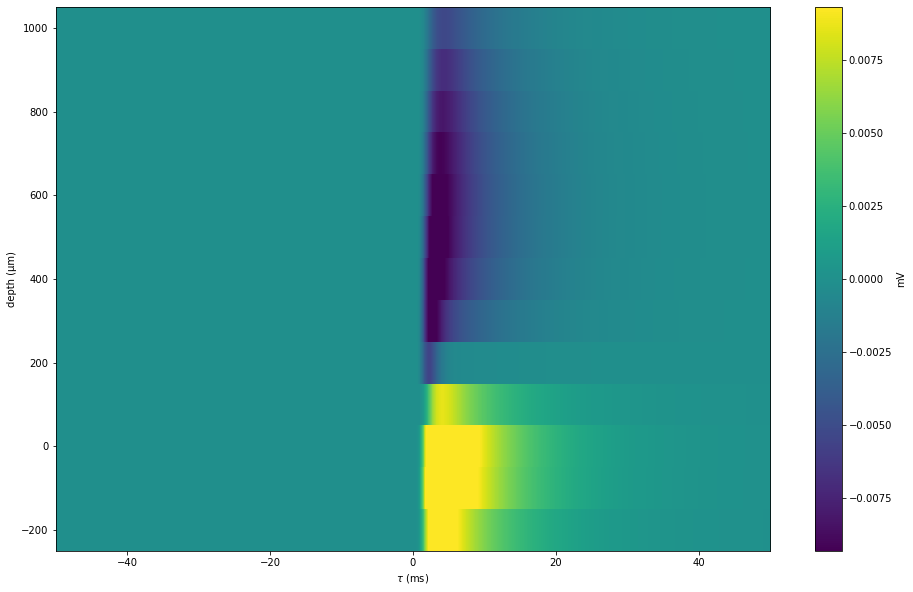

In [3]:
# display kernel
fig = plt.figure(figsize=(16, 10))
data = H['GaussCylinderPotential']
plt.imshow(data, 
           extent=[-tau, tau, probe.z.min()-50, probe.z.max()+50], 
           vmin=-abs(data).max() / 2, vmax=abs(data).max() / 2)
plt.axis('tight')
plt.xlabel(r'$\tau$ (ms)')
plt.ylabel('depth (µm)')
cb = plt.colorbar()
cb.set_label('mV')